Before you run any of the code below, please make sure that you have installed the necessary packages using the line of code below

In [1]:
#May need to install programmes in command prompt first with:
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org numpy
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org plotly (before dash if you get an error)
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org openpyxl
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org matplotlib (etc......)
#To run in browser need to use this web address http://127.0.0.1:2234/ (2234 you need to take from the port number at the end of this block of code after you run it) this will vary for each line of code below 


ALSO PLEASE NOTE THAT IF ANYTIME THE CODE SEEMS TO BE LAGGING WHEN YOU OPEN THE FOLLOWING BROWSER LINK ABOVE, PLEASE TRY RERUNNING THE CODE ON VSCODE THEN OPENING THE BROWSER AGAIN. ALSO PLEASE MAKE A SEPERATE COPY OF THIS CODE IN YOUR OWN FOLDER AND $$DO NOT$$ TRY TO RUN THIS CODE IN THE SAME FILE THAT IT IS STORED IN (ie Rheo Mystery FOLDER). IF ANY OTHER ISSUES WITH CODE PLEASE CONSULY LIAM RATCLIFFE 

WHERE TO GET THE DATA:
1) *OSCILLATORY RHEOLOGY* - Export data from the rheocompass software, refer to manual of oscillatory rheology technique for ice cream premixes on how to do this. Format for how the data in the table should look like is in the same file 
2) *ROTATIONAL RHEOLOGY* - Export data from core measurement data capture, link here https://unilever.sharepoint.com/sites/MastersizerDataCapture/Shared%20Documents/Forms/AllItems.aspx?id=%2Fsites%2FMastersizerDataCapture%2FShared%20Documents%2FData%2Frheology&viewid=a285c3e2%2D1131%2D4b23%2Db8fe%2D87166b191f9a. How data should look like is in the same file. 
3) *LASER DIFFRACTION* - Export data from powerbi core measurement dashboard, please note you will need to gain access to this and Erin Saunders is the main contact. (README FILE SHOWS YOU HOW TO GET THE DATA). LINK here https://app.powerbi.com/groups/me/reports/758f8046-0604-4bc1-9b96-759621caf169/ReportSectioncf78ad36fc49107a38f8?experience=power-bi&bookmarkGuid=Bookmark278ca0407fdd9fa970db. How data shoudl look like in same file. 

# FREQUENCY SWEEP

In [1]:
import pandas as pd
import numpy as np
from dash import Dash, html, dash_table, dcc, callback, Output, Input, State, ALL
import dash_daq as daq
import base64
import io
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# Initialize the app
app = Dash(__name__)

# Color and marker options
color_options = list(matplotlib.colors.cnames.keys())
marker_options = ['o', '^', 's', 'd', '+', 'x', '*']
font_options = ['Arial', 'Helvetica', 'Times New Roman', 'Courier New', 'Verdana', 'Georgia', 'Palatino', 'Garamond', 'Comic Sans MS', 'Impact']

# App layout
app.layout = html.Div([
    html.H1("Frequency sweep Data Analysis", style={'textAlign': 'center'}),
    dcc.Upload(
        id='upload-data',
        children=html.Button('Upload Excel File', style={'margin': '10px'}),
        multiple=False
    ),
    dcc.Dropdown(id='sheet-dropdown', placeholder="Select Sheet", style={'margin': '10px'}),
    dcc.Dropdown(id='test-dropdown', placeholder="Select Tests", multi=True, style={'margin': '10px'}),
    dcc.Dropdown(id='color-picker', options=[{'label': color, 'value': color} for color in color_options],
                 placeholder="Select Plot Color", multi=True, style={'margin': '10px'}),
    dcc.Dropdown(id='marker-picker', options=[{'label': marker, 'value': marker} for marker in marker_options],
                 placeholder="Select Interpolated Line Marker", multi=False, style={'margin': '10px'}),
    dcc.Dropdown(id='font-picker', options=[{'label': font, 'value': font} for font in font_options],
                 placeholder="Select Font Type", style={'margin': '10px'}),
    html.Div([
        dcc.Input(id='marker-size', type='number', placeholder='Marker Size', style={'margin': '10px'}),
    ]),
    html.Div([
        dcc.Input(id='x-min', type='number', placeholder='X-axis Min', style={'margin': '10px'}),
        dcc.Input(id='x-max', type='number', placeholder='X-axis Max', style={'margin': '10px'}),
        dcc.Input(id='interp-x-min', type='number', placeholder='Interpolation X-min', style={'margin': '10px'}),
        dcc.Input(id='interp-x-max', type='number', placeholder='Interpolation X-max', style={'margin': '10px'}),
        dcc.Checklist(
            id='gridlines-toggle',
            options=[{'label': 'Show Gridlines', 'value': 'show'}],
            value=['show'],
            style={'margin': '10px'}
        ),
        dcc.Checklist(
            id='find-g-equality',
            options=[{'label': 'Find G\' = G\" Point', 'value': 'find'}],
            value=[],
            style={'margin': '10px'}
        ),
        dcc.Checklist(
            id='plot-interpolated',
            options=[{'label': 'Plot Interpolated Lines', 'value': 'plot'}],
            value=[],
            style={'margin': '10px'}
        ),
    ]),
    html.Div(id='plot-labels-div'),
    html.Button('Add Plot Label', id='add-plot-label', n_clicks=0, style={'margin': '10px'}),
    html.Div([
        dcc.Input(id='font-size', type='number', placeholder='Font Size', style={'margin': '10px'}),
    ]),
    html.Div([
        dcc.Input(id='freq-specific', type='number', placeholder='Angular Frequency for Raw Data', style={'margin': '10px'}),
        dcc.Checklist(
            id='raw-data-toggle',
            options=[{'label': 'Get Raw Data at Specific Frequency', 'value': 'raw'}],
            value=[],
            style={'margin': '10px'}
        ),
    ]),
    dash_table.DataTable(id='data-table', page_size=10, style_table={'overflowX': 'auto'}),
    html.Div(id='raw-data-output', style={'margin': '10px'}),
    html.Div(id='plot-img'),
    html.Div(id='crossover-frequencies', style={'margin': '10px'}),
    html.Div(id='error-output', style={'color': 'red', 'margin': '10px'})
])

# Callback to add input fields for plot labels
@callback(
    Output('plot-labels-div', 'children'),
    Input('add-plot-label', 'n_clicks'),
    State('plot-labels-div', 'children')
)
def add_plot_labels(n_clicks, children):
    if children is None:
        children = []
    new_input = dcc.Input(id={'type': 'plot-label', 'index': n_clicks}, type='text', placeholder=f'Plot Label {n_clicks}', style={'margin': '10px'})
    children.append(new_input)
    return children

# Add controls to build the interaction
@callback(
    Output('sheet-dropdown', 'options'),
    Input('upload-data', 'contents'),
    State('upload-data', 'filename')
)
def update_sheet_dropdown(contents, filename):
    if contents is None:
        return []

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df = pd.ExcelFile(io.BytesIO(decoded))
    sheet_names = df.sheet_names
    return [{'label': sheet, 'value': sheet} for sheet in sheet_names]

@callback(
    Output('test-dropdown', 'options'),
    Input('sheet-dropdown', 'value'),
    State('upload-data', 'contents')
)
def update_test_dropdown(sheet_name, contents):
    if sheet_name is None or contents is None:
        return []

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df_tests = pd.read_excel(io.BytesIO(decoded), sheet_name=sheet_name, usecols=['Application:', 'Anton Paar RheoCompass™ V1.22.0.0'])
    df_tests['Application:'] = df_tests['Application:'].fillna('')
    df_tests = df_tests[df_tests['Application:'].str.startswith('Test:')]
    tests = df_tests['Anton Paar RheoCompass™ V1.22.0.0'].tolist()
    return [{'label': test, 'value': i} for i, test in enumerate(tests)]

@callback(
    Output('data-table', 'data'),
    Output('data-table', 'columns'),
    Output('plot-img', 'children'),
    Output('raw-data-output', 'children'),
    Output('crossover-frequencies', 'children'),
    Output('error-output', 'children'),  # New output for error messages
    Input('test-dropdown', 'value'),
    Input('color-picker', 'value'),
    Input('marker-picker', 'value'),
    Input('x-min', 'value'),
    Input('x-max', 'value'),
    Input('interp-x-min', 'value'),
    Input('interp-x-max', 'value'),
    Input('gridlines-toggle', 'value'),
    Input('find-g-equality', 'value'),
    Input('plot-interpolated', 'value'),
    Input({'type': 'plot-label', 'index': ALL}, 'value'),
    Input('font-size', 'value'),
    Input('font-picker', 'value'),
    Input('marker-size', 'value'),
    Input('freq-specific', 'value'),
    Input('raw-data-toggle', 'value'),
    State('sheet-dropdown', 'value'),
    State('upload-data', 'contents')
)
def update_output(selected_tests, selected_colors, marker, x_min, x_max, interp_x_min, interp_x_max, gridlines_toggle, find_g_equality, plot_interpolated, plot_labels, font_size, font_picker, marker_size, freq_specific, raw_data_toggle, sheet_name, contents):
    error_message = ""
    try:
        if not selected_tests or sheet_name is None or contents is None:
            return [], [], '', '', '', "No tests or data selected."

        if font_size is None:
            font_size = 12  # Set a default font size if None

        if font_picker is None:
            font_picker = 'Arial'  # Set a default font if None

        if marker_size is None:
            marker_size = 10  # Set a default marker size if None

        if selected_colors is None:
            selected_colors = color_options  # Set a default color list if None

        content_type, content_string = contents.split(',')
        decoded = base64.b64decode(content_string)
        df_data = pd.read_excel(io.BytesIO(decoded), sheet_name=sheet_name, usecols=[
            'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5','Unnamed: 6']).dropna(how='any')

        # Define the value to split the DataFrame on
        split_value = 'Storage Modulus'
       
        # Group the DataFrame by the value to split on
        grouped = df_data.groupby((df_data['Unnamed: 4'] == split_value).cumsum())
       
        # Create a list of the tables of data for each test
        df_list = [group for name, group in grouped if len(group) >= 3]

        # Ensure we have the same number of selected colors as tests
        selected_colors = selected_colors * (len(selected_tests) // len(selected_colors) + 1)

        # Prepare data and columns for the DataTable
        df_selected = pd.concat([df_list[i] for i in selected_tests])
        data = df_selected.to_dict('records')
        columns = [{'name': col, 'id': col} for col in df_selected.columns]

        # Plotting
        raw_data_output = []
        crossover_freq_output = []
        fig, ax = plt.subplots(figsize=(12,12))
       
        for i, test_index in enumerate(selected_tests):
            df_test = df_list[test_index]
            freq = df_test['Unnamed: 6'].iloc[2:].astype(float)
            storage_moduli = df_test['Unnamed: 4'].iloc[2:].astype(float)
            loss_moduli = df_test['Unnamed: 5'].iloc[2:].astype(float)

            # Interpolation range
            if interp_x_min is not None and interp_x_max is not None:
                mask = (freq >= interp_x_min) & (freq <= interp_x_max)
                freq_interp = freq[mask]
                storage_moduli_interp = storage_moduli[mask]
                loss_moduli_interp = loss_moduli[mask]

                # Interpolate data
                if len(freq_interp) > 1:  # Ensure there are enough points for interpolation
                    freq_new = np.logspace(np.log10(freq_interp.min()), np.log10(freq_interp.max()), num=500)
                    storage_moduli_interp = interp1d(freq_interp, storage_moduli_interp, kind='cubic')(freq_new)
                    loss_moduli_interp = interp1d(freq_interp, loss_moduli_interp, kind='cubic')(freq_new)
                else:
                    freq_new = np.array([])
                    storage_moduli_interp = np.array([])
                    loss_moduli_interp = np.array([])

            ax.plot(freq, storage_moduli, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'', color=selected_colors[i])
            ax.plot(freq, loss_moduli, '^-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\"', color=selected_colors[i])

            if 'plot' in plot_interpolated and len(freq_new) > 0:
                ax.plot(freq_new, storage_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\' Interpolated', color=selected_colors[i])
                ax.plot(freq_new, loss_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\" Interpolated', color=selected_colors[i])

            if 'find' in find_g_equality and len(freq_new) > 0:
                diff = np.abs(storage_moduli_interp - loss_moduli_interp)
                min_diff_index = np.argmin(diff)
                g_equality_freq = freq_new[min_diff_index]
                g_equality_value = storage_moduli_interp[min_diff_index]
               
                # Check if the crossover frequency is meaningful
                if diff[min_diff_index] < 1:  # You can adjust this threshold as needed
                    ax.plot(g_equality_freq, g_equality_value, marker=marker, markersize=marker_size, label=f'{plot_labels[i] if i < len(plot_labels) else test_index} Cross Over Point', color=selected_colors[i])
                    crossover_freq_output.append(html.P(f'{plot_labels[i] if i < len(plot_labels) else test_index}: G\'=G\" @ {g_equality_freq:.2f} rad/s'))

            if 'raw' in raw_data_toggle and freq_specific is not None:
                idx = np.abs(freq - freq_specific).argmin()
                raw_gp = storage_moduli.iloc[idx]
                raw_gpp = loss_moduli.iloc[idx]
                phase_shift_angle = np.degrees(np.arctan(loss_moduli.iloc[idx] / storage_moduli.iloc[idx]))
                loss_factor = loss_moduli.iloc[idx] / storage_moduli.iloc[idx]
                raw_data_output.append(html.Div([
                    html.P(f'{plot_labels[i] if i < len(plot_labels) else test_index}:'),
                    html.P(f'Frequency: {freq_specific} rad/s'),
                    html.P(f'G\': {raw_gp}'),
                    html.P(f'G\": {raw_gpp}'),
                    html.P(f'Phase Shift Angle: {phase_shift_angle} degrees'),
                    html.P(f'Loss Factor: {loss_factor}')
                ]))

        ax.set_xlabel('Angular Frequency, ω/rad$s^{-1}$', fontname=font_picker, fontsize=font_size)
        ax.set_ylabel('G\' & G\" /Pa', fontname=font_picker, fontsize=font_size)
        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.yaxis.set_major_formatter('{:.2f}'.format)
        ax.xaxis.set_major_formatter('{:.2f}'.format)
        ax.legend(prop={'family': font_picker, 'size': font_size})
        if 'show' in gridlines_toggle:
            ax.grid(True)
            ax.grid(which='minor', color='#EEEEEE')
        else:
            ax.grid(False)

        # Ensure x-axis and y-axis solid lines with ticks
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=font_size)
        ax.spines['top'].set_linewidth(1.5)
        ax.spines['right'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)

        if x_min is not None and x_max is not None:
            ax.set_xlim([x_min, x_max])
        plt.close(fig)
        plt.clf()

        # Convert plot to PNG image
        output = io.BytesIO()
        FigureCanvas(fig).print_png(output)
        encoded_image = base64.b64encode(output.getvalue()).decode('utf-8')
        img_src = f'data:image/png;base64,{encoded_image}'

        return data, columns, html.Img(src=img_src), raw_data_output, crossover_freq_output, ""

    except Exception as e:
        error_message = f"An error occurred: {str(e)}"
        return [], [], '', '', '', error_message


# Run the app then tyoe this http://127.0.0.1:2235/ to run in browser
if __name__ == '__main__':
    app.run(port=2235)


# STRAIN SWEEP

Rules to make sure when using this code 
To plot G' vs strain and use analysis **MOST IMPORTANT AND RELEVANT**:
1) DO NOT TYPE ANYTHING IN THE INTERPOLATED XMIN AND XMAX, IF YOU DO PLEASE RE RUN THIS LINE OF CODE ON VS CODE THEN OPENING UP THE BROWSER 
2) YOU CAN USE ALL THE OTHER LINES AND ALSO FILL IN THE LAST LINE TO GET THE YIEDL STRAIN (FILL IN THIS LINE ALSO TO GET THE RANGE TO FIND THE MAX STRAIN)
PLEASE CONSULT LIAM RATCLIFFE ON THE SCIENCE AND RHEOLOGY ASPECT OF YOUR PROJECT IF YOU WOULD LIKE TO USE THE OTHER ANALYSIS SECTIONS PROVIDED 

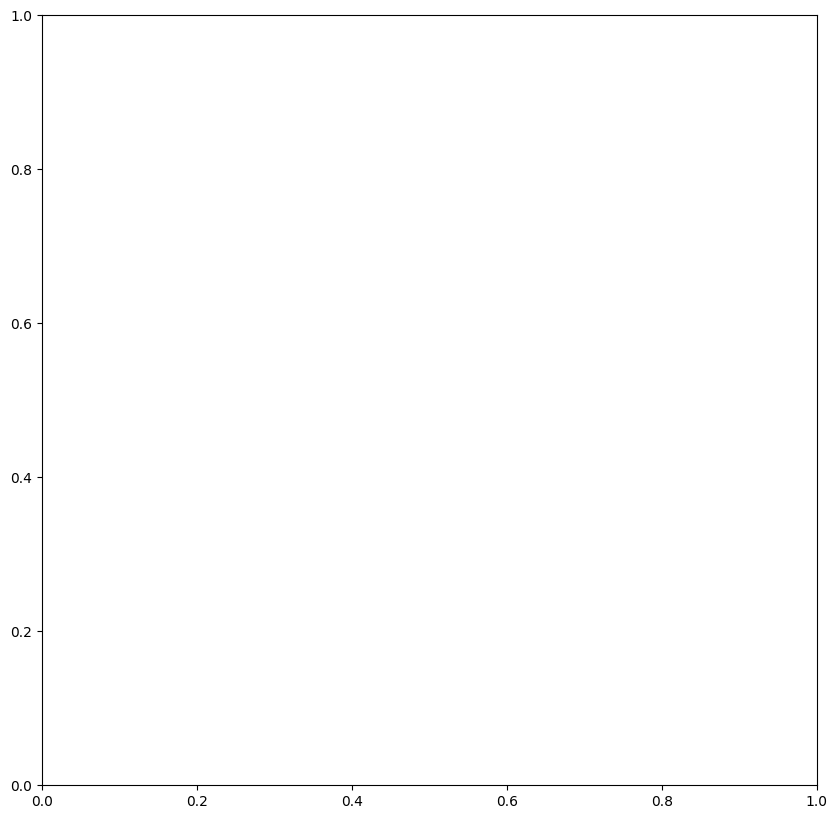

In [69]:
import pandas as pd
import numpy as np
from dash import Dash, html, dcc, callback, Output, Input, State, dash_table, ALL
import base64
import io
from scipy.interpolate import interp1d, CubicSpline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# Initialize the app
app = Dash(__name__)

# Color and marker options
color_options=[]
for name, hex in matplotlib.colors.cnames.items():
    color_options.append(name)
marker_options = ['o', '^', 's', 'd', '+', 'x', '*']
font_options = ['Arial', 'Helvetica', 'Times New Roman', 'Courier New', 'Verdana', 'Georgia', 'Palatino', 'Garamond', 'Comic Sans MS', 'Impact']

# App layout
app.layout = html.Div([
    html.H1("Strain Sweep Data Analysis", style={'textAlign': 'center'}),
    dcc.Upload(
        id='upload-data',
        children=html.Button('Upload Excel File', style={'margin': '10px'}),
        multiple=False
    ),
    dcc.Dropdown(id='sheet-dropdown', placeholder="Select Sheet", style={'margin': '10px'}),
    dcc.Dropdown(id='test-dropdown', placeholder="Select Tests", multi=True, style={'margin': '10px'}),
    dcc.Dropdown(id='plot-type-dropdown', options=[
        {'label': "G' & G'' vs Strain", 'value': 'G_vs_Strain'},
        {'label': "G' & G'' vs Stress", 'value': 'G_vs_Stress'},
        {'label': "G' vs Strain", 'value': 'G_prime_vs_Strain'},
        {'label': "Stress vs Strain", 'value': 'Stress_vs_Strain'},
        {'label': "G'*Strain vs Strain", 'value': 'G_strain_vs_Strain'},
        {'label': "G\' vs stress",'value':'G\'_vs_stress'}
    ], placeholder="Select Plot Type", style={'margin': '10px'}),
    dcc.Dropdown(id='color-picker', options=[{'label': color, 'value': color} for color in color_options],
                 placeholder="Select Plot Color", multi=True, style={'margin': '10px'}),
    dcc.Dropdown(id='marker-picker', options=[{'label': marker, 'value': marker} for marker in marker_options],
                 placeholder="Select Interpolated Line Marker", multi=False, style={'margin': '10px'}),
    dcc.Dropdown(id='font-picker', options=[{'label': font, 'value': font} for font in font_options],
                 placeholder="Select Font Type", style={'margin': '10px'}),
    html.Div([
        dcc.Input(id='marker-size', type='number', placeholder='Marker Size', style={'margin': '10px'}),
    ]),
    html.Div([
        dcc.Input(id='x-min', type='number', placeholder='X-axis Min', style={'margin': '10px'}),
        dcc.Input(id='x-max', type='number', placeholder='X-axis Max', style={'margin': '10px'}),
        dcc.Input(id='interp-x-min', type='number', placeholder='Interpolation X-min', style={'margin': '10px'}),
        dcc.Input(id='interp-x-max', type='number', placeholder='Interpolation X-max', style={'margin': '10px'}),
        dcc.Checklist(
            id='gridlines-toggle',
            options=[{'label': 'Show Gridlines', 'value': 'show'}],
            value=['show'],
            style={'margin': '10px'}
        ),
        dcc.Checklist(
            id='plot-interpolated',
            options=[{'label': 'Plot Interpolated Lines', 'value': 'plot'}],
            value=[],
            style={'margin': '10px'}
        ),
    ]),
    html.Div(id='plot-labels-div'),
    html.Button('Add Plot Label', id='add-plot-label', n_clicks=0, style={'margin': '10px'}),
    html.Div([
        dcc.Input(id='font-size', type='number', placeholder='Font Size', style={'margin': '10px'}),
    ]),
    dash_table.DataTable(id='data-table', page_size=10, style_table={'overflowX': 'auto'}),
    html.Div(id='plot-img'),
    dcc.Dropdown(id='analysis-dropdown', options=[
        {'label': "Maximum Stress from Stress vs Strain", 'value': 'max_stress'},
        {'label': "Maximum G'*Strain from G'*Strain vs Strain", 'value': 'max_G_strain'},
        {'label': "Maximum G' from G' vs Strain", 'value': 'max_G_prime'},
        {'label': "Find Yield Point from Stress vs Strain", 'value': 'yield_point'},
        {'label': "Find Yield Strain from G' vs Strain", 'value': 'yield_strain'},
        {'label': "Find Crossover Point from G' & G'' vs Stress", 'value': 'crossover_point'},
        {'label': 'Find the Yield Point form G\' vs Stress', 'value': 'yield_point_stress'}
    ], placeholder="Select Analysis Type", style={'margin': '10px'}),
    html.Div(id='analysis-result', style={'margin': '10px'}),
    html.Div(id='yield-strain-range', children=[
        html.Label('Select Range for Yield Strain:'),
        dcc.Input(id='yield-strain-min', type='number', placeholder='Min X', style={'margin': '10px'}),
        dcc.Input(id='yield-strain-max', type='number', placeholder='Max X', style={'margin': '10px'})
    ], style={'display': 'none'})
])

# Callback to show/hide the yield strain range input based on analysis type
@callback(
    Output('yield-strain-range', 'style'),
    Input('analysis-dropdown', 'value')
)
def toggle_yield_strain_range(analysis_type):
    if analysis_type == 'yield_strain' or 'yield_point_stress':
        return {'display': 'block'}
    else:
        return {'display': 'none'}

# Callback to add input fields for plot labels
@callback(
    Output('plot-labels-div', 'children'),
    Input('add-plot-label', 'n_clicks'),
    State('plot-labels-div', 'children')
)
def add_plot_labels(n_clicks, children):
    if children is None:
        children = []
    new_input = dcc.Input(id={'type': 'plot-label', 'index': n_clicks}, type='text', placeholder=f'Plot Label {n_clicks}', style={'margin': '10px'})
    children.append(new_input)
    return children

# Callback to update sheet dropdown based on uploaded file
@callback(
    Output('sheet-dropdown', 'options'),
    Input('upload-data', 'contents'),
    State('upload-data', 'filename')
)
def update_sheet_dropdown(contents, filename):
    if contents is None:
        return []

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df = pd.ExcelFile(io.BytesIO(decoded))
    sheet_names = df.sheet_names
    return [{'label': sheet, 'value': sheet} for sheet in sheet_names]

# Callback to update test dropdown based on selected sheet
@callback(
    Output('test-dropdown', 'options'),
    Input('sheet-dropdown', 'value'),
    State('upload-data', 'contents')
)
def update_test_dropdown(sheet_name, contents):
    if sheet_name is None or contents is None:
        return []

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df_tests = pd.read_excel(io.BytesIO(decoded), sheet_name=sheet_name, usecols=['Application:', 'Anton Paar RheoCompass™ V1.22.0.0'])
    df_tests['Application:'] = df_tests['Application:'].fillna('')
    df_tests = df_tests[df_tests['Application:'].str.startswith('Test:')]
    tests = df_tests['Anton Paar RheoCompass™ V1.22.0.0'].tolist()
    return [{'label': test, 'value': i} for i, test in enumerate(tests)]

# Callback to update data table and plot based on selected tests and options
@callback(
    Output('data-table', 'data'),
    Output('data-table', 'columns'),
    Output('plot-img', 'children'),
    Output('analysis-result', 'children'),
    Input('test-dropdown', 'value'),
    Input('plot-type-dropdown', 'value'),
    Input('color-picker', 'value'),
    Input('marker-picker', 'value'),
    Input('x-min', 'value'),
    Input('x-max', 'value'),
    Input('interp-x-min', 'value'),
    Input('interp-x-max', 'value'),
    Input('gridlines-toggle', 'value'),
    Input('plot-interpolated', 'value'),
    Input({'type': 'plot-label', 'index': ALL}, 'value'),
    Input('font-size', 'value'),
    Input('font-picker', 'value'),
    Input('marker-size', 'value'),
    Input('analysis-dropdown', 'value'),
    Input('yield-strain-min', 'value'),
    Input('yield-strain-max', 'value'),
    State('sheet-dropdown', 'value'),
    State('upload-data', 'contents')
)
def update_output(selected_tests, plot_type, selected_colors, marker, x_min, x_max, interp_x_min, interp_x_max, gridlines_toggle, plot_interpolated, plot_labels, font_size, font_picker, marker_size, analysis_type, yield_strain_min, yield_strain_max, sheet_name, contents):
    if not selected_tests or sheet_name is None or contents is None or plot_type is None:
        return [], [], '', ''

    if font_size is None:
        font_size = 12  # Set a default font size if None

    if font_picker is None:
        font_picker = 'Arial'  # Set a default font if None

    if marker_size is None:
        marker_size = 10  # Set a default marker size if None

    if selected_colors is None:
        selected_colors = color_options  # Set a default color list if None

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df_data = pd.read_excel(io.BytesIO(decoded), sheet_name=sheet_name, usecols=[
        'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']).dropna(how='any')

    # Define the value to split the DataFrame on
    split_value = 'Storage Modulus'
   
    # Group the DataFrame by the value to split on
    grouped = df_data.groupby((df_data['Unnamed: 4'] == split_value).cumsum())
   
    # Create a list of the tables of data for each test
    df_list = [group for name, group in grouped if len(group) >= 3]

    # Ensure we have the same number of selected colors as tests
    selected_colors = selected_colors * (len(selected_tests) // len(selected_colors) + 1)

    # Prepare data and columns for the DataTable
    df_selected = pd.concat([df_list[i] for i in selected_tests])
    data = df_selected.to_dict('records')
    columns = [{'name': col, 'id': col} for col in df_selected.columns]

    # Plotting
    fig, ax = plt.subplots(figsize=(10,10))


  

    max_values = []
    yield_points = []
    crossover_points = []

    for i, test_index in enumerate(selected_tests):
        df_test = df_list[test_index].reset_index(drop=True)
        strain = df_test['Unnamed: 2'].iloc[2:].astype(float).reset_index(drop=True)*100
        storage_moduli = df_test['Unnamed: 4'].iloc[2:].astype(float).reset_index(drop=True)
        loss_moduli = df_test['Unnamed: 5'].iloc[2:].astype(float).reset_index(drop=True)
        stress = df_test['Unnamed: 3'].iloc[2:].astype(float).reset_index(drop=True)
        g_strain = storage_moduli * strain

        # Interpolation range
        if interp_x_min is not None and interp_x_max is not None:
            mask = (strain >= interp_x_min) & (strain <= interp_x_max)
            strain_interp = strain[mask]
            storage_moduli_interp = storage_moduli[mask]
            loss_moduli_interp = loss_moduli[mask]
            stress_interp = stress[mask]
            g_strain_interp = g_strain[mask]

            # Interpolate data
            strain_new = np.logspace(np.log10(strain_interp.min()), np.log10(strain_interp.max()), num=500)
            storage_moduli_interp = interp1d(strain_interp, storage_moduli_interp, kind='cubic')(strain_new)
            loss_moduli_interp = interp1d(strain_interp, loss_moduli_interp, kind='cubic')(strain_new)
            stress_interp = interp1d(strain_interp, stress_interp, kind='cubic')(strain_new)
            g_strain_interp = interp1d(strain_interp, g_strain_interp, kind='cubic')(strain_new)

        if plot_type == 'G_vs_Strain':
            ax.plot(strain, storage_moduli, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'', color=selected_colors[i])
            ax.plot(strain, loss_moduli, '^-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\"', color=selected_colors[i])
            if 'plot' in plot_interpolated and interp_x_min is not None and interp_x_max is not None:
                ax.plot(strain_new, storage_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\' Interpolated', color=selected_colors[i])
                ax.plot(strain_new, loss_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\" Interpolated', color=selected_colors[i])
        elif plot_type == 'G_vs_Stress':
            ax.plot(stress, storage_moduli, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'', color=selected_colors[i])
            ax.plot(stress, loss_moduli, '^-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\"', color=selected_colors[i])
            if 'plot' in plot_interpolated and interp_x_min is not None and interp_x_max is not None:
                ax.plot(stress_interp, storage_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\' Interpolated', color=selected_colors[i])
                ax.plot(stress_interp, loss_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\" Interpolated', color=selected_colors[i])
        elif plot_type == 'G_prime_vs_Strain':
            ax.plot(strain, storage_moduli, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'', color=selected_colors[i])
            if 'plot' in plot_interpolated and interp_x_min is not None and interp_x_max is not None:
                ax.plot(strain_new, storage_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\' Interpolated', color=selected_colors[i])
        elif plot_type == 'Stress_vs_Strain':
            ax.plot(strain, stress, 's-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} Stress', color=selected_colors[i])
            if 'plot' in plot_interpolated and interp_x_min is not None and interp_x_max is not None:
                ax.plot(strain_new, stress_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} Stress Interpolated', color=selected_colors[i])
        elif plot_type == 'G_strain_vs_Strain':
            ax.plot(strain, g_strain, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'*Strain', color=selected_colors[i])
            if 'plot' in plot_interpolated and interp_x_min is not None and interp_x_max is not None:
                ax.plot(strain_new, g_strain_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'*Strain Interpolated', color=selected_colors[i])
        elif plot_type == 'G\'_vs_stress':
             ax.plot(stress, storage_moduli, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'', color=selected_colors[i])
             if 'plot' in plot_interpolated and interp_x_min is not None and interp_x_max is not None:
                ax.plot(stress_interp, storage_moduli_interp, f'{marker}-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index} G\'Interpolated', color=selected_colors[i])
        # plt.clf()


        # Find the maximum value based on the analysis type
        if analysis_type == 'max_stress' and plot_type == 'Stress_vs_Strain':
            max_stress = stress.max()
            max_strain_at_max_stress = strain[stress.idxmax()]
            max_values.append(f'Maximum Stress for {plot_labels[i] if i < len(plot_labels) else test_index}: {max_stress:.4f} Pa')
            ax.plot(max_strain_at_max_stress, max_stress, 'ro', label=f'Max Stress: {max_stress:.4f} Pa')
        elif analysis_type == 'max_G_strain' and plot_type == 'G_strain_vs_Strain':
            max_g_strain = g_strain.max()
            max_strain_at_max_g_strain = strain[g_strain.idxmax()]
            max_values.append(f'Maximum G\'*Strain for {plot_labels[i] if i < len(plot_labels) else test_index}: {max_g_strain:.4f}')
            ax.plot(max_strain_at_max_g_strain, max_g_strain, 'ro', label=f'Max G\'*Strain: {max_g_strain:.4f}')
        elif analysis_type == 'max_G_prime' and plot_type == 'G_prime_vs_Strain'and yield_strain_min is not None and yield_strain_max is not None:
            max_g_prime = storage_moduli[6:].max()
            max_strain_at_max_g_prime = strain[storage_moduli.idxmax()]
            max_values.append(f'Maximum G\' for {plot_labels[i] if i < len(plot_labels) else test_index}: {max_g_prime:.4f} Pa')
            ax.plot(max_strain_at_max_g_prime, max_g_prime, 'ro', label=f'Max G\': {max_g_prime:.4f} Pa')
        elif analysis_type == 'yield_point' and plot_type == 'Stress_vs_Strain':
            # Perform linear regression on the first and last 10 points
            first_10_strain = np.log10(strain[:10])
            first_10_stress = np.log10(stress[:10])
            last_10_strain = np.log10(strain[-17:-8])
            last_10_stress = np.log10(stress[-17:-8])
           
            coeffs_first_10 = np.polyfit(first_10_strain, first_10_stress, 1)
            coeffs_last_10 = np.polyfit(last_10_strain, last_10_stress, 1)
           
            # Find the intersection point of the two lines
            intersection_x = (coeffs_last_10[1] - coeffs_first_10[1]) / (coeffs_first_10[0] - coeffs_last_10[0])
            intersection_x = 10 ** intersection_x
            intersection_y = 10 ** (coeffs_first_10[0] * np.log10(intersection_x) + coeffs_first_10[1])
           
            yield_points.append(f'Yield Point for {plot_labels[i] if i < len(plot_labels) else test_index}: {intersection_x:.4f} Strain, {intersection_y:.4f} Pa')
            ax.plot(intersection_x, intersection_y, 'bo', label=f'Yield Point: {intersection_x:.4f} Strain, {intersection_y:.4f} Pa')

            # Plot the fitted lines
            strain_fit = np.logspace(np.log10(strain.min()), np.log10(strain.max()), 500)
            stress_fit_first_10 = 10 ** np.polyval(coeffs_first_10, np.log10(strain_fit))
            stress_fit_last_10 = 10 ** np.polyval(coeffs_last_10, np.log10(strain_fit))
            ax.plot(strain_fit, stress_fit_first_10, 'k--')
            ax.plot(strain_fit, stress_fit_last_10, 'k--')
        elif analysis_type == 'yield_strain' and plot_type == 'G_prime_vs_Strain' and yield_strain_min is not None and yield_strain_max is not None:
            # Perform linear regression within the selected range
            coefficients_first_10 = np.polyfit(np.log10(strain[0:8]), np.log10(storage_moduli[0:8]), 1)
            coefficients_last_10 = np.polyfit(np.log10(strain[-16:-10]), np.log10(storage_moduli[-16:-10]), 1)

            # Find the intersection point of the two lines
            intersection_x = 10 ** ((coefficients_last_10[1] - coefficients_first_10[1]) / (coefficients_first_10[0] - coefficients_last_10[0]))
            intersection_y = 10 ** np.polyval(coefficients_first_10, np.log10(intersection_x))

            yield_points.append(f'Yield Strain for {plot_labels[i] if i < len(plot_labels) else test_index}: {intersection_x:.4f} Strain')
            ax.plot(intersection_x, intersection_y, 'bo', label=f'Yield Strain: {intersection_x:.4f} Strain')

            # Generate points for the fitted lines
            x_fit_first_10 = np.logspace(np.log10(min(strain[:])), np.log10(max(strain[:])), 100)
            x_fit_last_10 = np.logspace(np.log10(min(strain[:])), np.log10(max(strain[:])), 100)
            y_fit_first_10 = 10 ** np.polyval(coefficients_first_10, np.log10(x_fit_first_10))
            y_fit_last_10 = 10 ** np.polyval(coefficients_last_10, np.log10(x_fit_last_10))
            ax.plot(x_fit_first_10, y_fit_first_10, 'k--')
            ax.plot(x_fit_last_10, y_fit_last_10, 'k--')
        elif analysis_type == 'crossover_point' and plot_type == 'G_vs_Stress':
            # Ensure data is sorted by stress
            sorted_indices = stress.argsort()
            stress_sorted = stress[sorted_indices]
            storage_moduli_sorted = storage_moduli[sorted_indices]
            loss_moduli_sorted = loss_moduli[sorted_indices]

            # Find the crossover point where G' and G'' are equal using interpolation
            cs_storage_moduli = CubicSpline(stress_sorted, storage_moduli_sorted)
            cs_loss_moduli = CubicSpline(stress_sorted, loss_moduli_sorted)
            stress_new = np.linspace(stress_sorted.min(), stress_sorted.max(), 1000)
            storage_moduli_new = cs_storage_moduli(stress_new)
            loss_moduli_new = cs_loss_moduli(stress_new)
            diff = np.abs(storage_moduli_new - loss_moduli_new)
            min_diff_index = np.argmin(diff)
            crossover_stress = stress_new[min_diff_index]
            crossover_value = storage_moduli_new[min_diff_index]

            crossover_points.append(f'Crossover Point for {plot_labels[i] if i < len(plot_labels) else test_index}: {crossover_stress:.4f} Pa')
            ax.plot(crossover_stress, crossover_value, 'go', label=f'Crossover Point: {crossover_stress:.4f} Pa')

        elif analysis_type == 'yield_point_stress' and plot_type == 'G\'_vs_stress':
            # Perform linear regression within the selected range
            coefficients_first_10 = np.polyfit(np.log10(stress[0:8]), np.log10(storage_moduli[0:8]), 1)
            coefficients_last_10 = np.polyfit(np.log10(stress[-16:-10]), np.log10(storage_moduli[-16:-10]), 1)

            # Find the intersection point of the two lines
            intersection_x = 10 ** ((coefficients_last_10[1] - coefficients_first_10[1]) / (coefficients_first_10[0] - coefficients_last_10[0]))
            intersection_y = 10 ** np.polyval(coefficients_first_10, np.log10(intersection_x))

            yield_points.append(f'Yield Stress for {plot_labels[i] if i < len(plot_labels) else test_index}: {intersection_x:.4f} Stress')
            ax.plot(intersection_x, intersection_y, 'bo', label=f'Yield Stress: {intersection_x:.4f} Stress')

            # Generate points for the fitted lines
            x_fit_first_10 = np.logspace(np.log10(min(stress[:])), np.log10(max(stress[:])), 100)
            x_fit_last_10 = np.logspace(np.log10(min(stress[:])), np.log10(max(stress[:])), 100)
            y_fit_first_10 = 10 ** np.polyval(coefficients_first_10, np.log10(x_fit_first_10))
            y_fit_last_10 = 10 ** np.polyval(coefficients_last_10, np.log10(x_fit_last_10))
            ax.plot(x_fit_first_10, y_fit_first_10, 'k--')
            ax.plot(x_fit_last_10, y_fit_last_10, 'k--')
        

    # Set axis labels
    if plot_type == 'G_vs_Strain' or plot_type == 'G_prime_vs_Strain' or plot_type == 'G_strain_vs_Strain':
        ax.set_xlabel('Strain (%)', fontname=font_picker, fontsize=font_size)
        if plot_type == 'G_vs_Strain':
            ax.set_ylabel('G\' & G\" (Pa)', fontname=font_picker, fontsize=font_size)
        elif plot_type == 'G_prime_vs_Strain':
            ax.set_ylabel('G\' (Pa)', fontname=font_picker, fontsize=font_size)
        elif plot_type == 'G_strain_vs_Strain':
            ax.set_ylabel('G\'*Strain/Pa', fontname=font_picker, fontsize=font_size)
    elif plot_type == 'G_vs_Stress':
        ax.set_xlabel('Stress (Pa)', fontname=font_picker, fontsize=font_size)
        ax.set_ylabel('G\' & G\" (Pa)', fontname=font_picker, fontsize=font_size)
    elif plot_type == 'Stress_vs_Strain':
        ax.set_xlabel('Strain (%)', fontname=font_picker, fontsize=font_size)
        ax.set_ylabel('Stress (Pa)', fontname=font_picker, fontsize=font_size)
    elif plot_type == 'G\'_vs_stress':
        ax.set_xlabel('Stress (Pa)', fontname=font_picker, fontsize=font_size)
        ax.set_ylabel('G\' (Pa)', fontname=font_picker, fontsize=font_size)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.yaxis.set_major_formatter('{:.4f}'.format)
    ax.xaxis.set_major_formatter('{:.4f}'.format)
    ax.legend(prop={'family': font_picker, 'size': font_size})
    if 'show' in gridlines_toggle:
        ax.grid(True)
        ax.grid(which='minor', color='#EEEEEE')
    else:
        ax.grid(False)

    # Ensure x-axis and y-axis solid lines with ticks
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=font_size)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    if x_min is not None and x_max is not None:
        ax.set_xlim([x_min, x_max])
    plt.close(fig)

    # Convert plot to PNG image
    output = io.BytesIO()
    FigureCanvas(fig).print_png(output)
    encoded_image = base64.b64encode(output.getvalue()).decode('utf-8')
    img_src = f'data:image/png;base64,{encoded_image}'

    return data, columns, html.Img(src=img_src), html.Div(max_values + yield_points + crossover_points)
# plt.clf()
# Run the app then tyoe this http://127.0.0.1:2229/ to run in browser
if __name__ == '__main__':
    app.run_server(port=2229)

# ROTATIONAL RHEOLOGY 

In [72]:
# Import necessary packages
import pandas as pd
import numpy as np
from dash import Dash, html, dash_table, dcc, callback, Output, Input, State, ALL
import dash_daq as daq
import base64
import io
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib

# Initialize the app
app = Dash(__name__)

# Color and marker options
color_options=[]
for name, hex in matplotlib.colors.cnames.items():
    color_options.append(name)

font_options = ['Arial', 'Helvetica', 'Times New Roman', 'Courier New', 'Verdana', 'Georgia', 'Palatino', 'Garamond', 'Comic Sans MS', 'Impact']

# App layout
app.layout = html.Div([
    html.H1("Rotational rheology Data Analysis", style={'textAlign': 'center'}),
    dcc.Upload(
        id='upload-data',
        children=html.Button('Upload Excel File', style={'margin': '10px'}),
        multiple=False
    ),
    dcc.Dropdown(id='sheet-dropdown', placeholder="Select Sheet", style={'margin': '10px'}),
    dcc.Dropdown(id='test-dropdown', placeholder="Select Tests", multi=True, style={'margin': '10px'}),
    dcc.Dropdown(id='color-picker', options=[{'label': color, 'value': color} for color in color_options],
                 placeholder="Select Plot Color", multi=True, style={'margin': '10px'}),
    dcc.Dropdown(id='font-picker', options=[{'label': font, 'value': font} for font in font_options],
                 placeholder="Select Font Type", style={'margin': '10px'}),
    html.Div([
        dcc.Input(id='marker-size', type='number', placeholder='Marker Size', style={'margin': '10px'}),
    ]),
    html.Div([
        dcc.Input(id='x-min', type='number', placeholder='X-axis Min', style={'margin': '10px'}),
        dcc.Input(id='x-max', type='number', placeholder='X-axis Max', style={'margin': '10px'}),
        dcc.Input(id='y-min', type='number', placeholder='Y-axis Min', style={'margin': '10px'}),
        dcc.Input(id='y-max', type='number', placeholder='Y-axis Max', style={'margin': '10px'}),
        dcc.Checklist(
            id='gridlines-toggle',
            options=[{'label': 'Show Gridlines', 'value': 'show'}],
            value=['show'],
            style={'margin': '10px'}
        )
    ]),
    html.Div(id='plot-labels-div'),
    html.Button('Add Plot Label', id='add-plot-label', n_clicks=0, style={'margin': '10px'}),
    html.Div([
        dcc.Input(id='font-size', type='number', placeholder='Font Size', style={'margin': '10px'}),
    ]),

    dash_table.DataTable(id='data-table', page_size=10, style_table={'overflowX': 'auto'}),
    html.Div(id='plot-img')
])

# Callback to add input fields for plot labels
@callback(
    Output('plot-labels-div', 'children'),
    Input('add-plot-label', 'n_clicks'),
    State('plot-labels-div', 'children')
)
def add_plot_labels(n_clicks, children):
    if children is None:
        children = []
    new_input = dcc.Input(id={'type': 'plot-label', 'index': n_clicks}, type='text', placeholder=f'Plot Label {n_clicks}', style={'margin': '10px'})
    children.append(new_input)
    return children

# Add controls to build the interaction
@callback(
    Output('sheet-dropdown', 'options'),
    Input('upload-data', 'contents'),
    State('upload-data', 'filename')
)
def update_sheet_dropdown(contents, filename):
    if contents is None:
        return []

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df = pd.ExcelFile(io.BytesIO(decoded))
    sheet_names = df.sheet_names
    return [{'label': sheet, 'value': sheet} for sheet in sheet_names]

@callback(
    Output('test-dropdown', 'options'),
    Input('sheet-dropdown', 'value'),
    State('upload-data', 'contents')
)
def update_test_dropdown(sheet_name, contents):
    if sheet_name is None or contents is None:
        return []

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df_tests = pd.read_excel(io.BytesIO(decoded), sheet_name=sheet_name, usecols=['Application:', 'Anton Paar RheoCompass™ V1.22.0.0'])
    df_tests['Application:'] = df_tests['Application:'].fillna('')
    df_tests = df_tests[df_tests['Application:'].str.startswith('Test:')]
    tests = df_tests['Anton Paar RheoCompass™ V1.22.0.0'].tolist()
    return [{'label': test, 'value': i} for i, test in enumerate(tests)]

@callback(
    Output('data-table', 'data'),
    Output('data-table', 'columns'),
    Output('plot-img', 'children'),
    Input('test-dropdown', 'value'),
    Input('color-picker', 'value'),
    Input('x-min', 'value'),
    Input('x-max', 'value'),
    Input('y-min', 'value'),
    Input('y-max', 'value'),
    Input('gridlines-toggle', 'value'),
    Input({'type': 'plot-label', 'index': ALL}, 'value'),
    Input('font-size', 'value'),
    Input('font-picker', 'value'),
    Input('marker-size', 'value'),
    State('sheet-dropdown', 'value'),
    State('upload-data', 'contents')
)
def update_output(selected_tests, selected_colors, x_min, x_max,y_min,y_max,gridlines_toggle, plot_labels, font_size, font_picker, marker_size, sheet_name, contents):
    if not selected_tests or sheet_name is None or contents is None:
        return [], [], ''

    if font_size is None:
        font_size = 12  # Set a default font size if None

    if font_picker is None:
        font_picker = 'Arial'  # Set a default font if None

    if marker_size is None:
        marker_size = 10  # Set a default marker size if None

    if selected_colors is None:
        selected_colors = color_options  # Set a default color list if None

    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    df_data = pd.read_excel(io.BytesIO(decoded), sheet_name=sheet_name, usecols=[
        'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']).dropna(how='any')

    # Define the value to split the DataFrame on
    split_value = 'Viscosity'
   
    # Group the DataFrame by the value to split on
    grouped = df_data.groupby((df_data['Unnamed: 4'] == split_value).cumsum())
   
    # Create a list of the tables of data for each test
    df_list = [group for name, group in grouped if len(group) >= 5]

    # # Ensure we have the same number of selected colors as tests
    selected_colors = selected_colors * (len(selected_tests) // len(selected_colors) + 1)

    # Prepare data and columns for the DataTable
    df_selected = pd.concat([df_list[i] for i in selected_tests])
    data = df_selected.to_dict('records')
    columns = [{'name': col, 'id': col} for col in df_selected.columns]

    # Plotting
    fig, ax = plt.subplots(figsize=(12,12))

    for i, test_index in enumerate(selected_tests):
        df_test = df_list[test_index]
        shear_rate = df_test['Unnamed: 3'].iloc[2:].astype(float)
        viscosity = df_test['Unnamed: 4'].iloc[2:].astype(float)

        ax.plot(shear_rate, viscosity, 'o-', label=f'{plot_labels[i] if i < len(plot_labels) else test_index}', color=selected_colors[i])

    ax.set_xlabel('Shear rate, $\gamma$/$s^{-1}$', fontname=font_picker, fontsize=font_size)
    ax.set_ylabel('Viscosity, $\eta$/Pa.s', fontname=font_picker, fontsize=font_size)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.yaxis.set_major_formatter('{:.2f}'.format)
    ax.xaxis.set_major_formatter('{:.2f}'.format)
    ax.legend(prop={'family': font_picker, 'size': font_size})
    if 'show' in gridlines_toggle:
        ax.grid(True)
        ax.grid(which='minor', color='#EEEEEE')
    else:
        ax.grid(False)

    # Ensure x-axis and y-axis solid lines with ticks
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=font_size)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    if x_min is not None and x_max is not None:
        ax.set_xlim([x_min, x_max])
    if y_min is not None and y_max is not None:
        ax.set_ylim([y_min, y_max])
    plt.close(fig)

    # Convert plot to PNG image
    output = io.BytesIO()
    FigureCanvas(fig).print_png(output)
    encoded_image = base64.b64encode(output.getvalue()).decode('utf-8')
    img_src = f'data:image/png;base64,{encoded_image}'

    return data, columns, html.Img(src=img_src)

# Run the app then tyoe this http://127.0.0.1:2240/ to run in browser
if __name__ == '__main__':
    app.run(port=2240)

# LASER DIFFRACTION 

In [74]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State, ALL
import pandas as pd
import base64
import io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

app = dash.Dash(__name__)

# Extract the color names from matplotlib
color_options = [{'label': color, 'value': color} for color in mcolors.CSS4_COLORS]
font_options = ['Arial', 'Helvetica', 'Times New Roman', 'Courier New', 'Verdana', 'Georgia', 'Palatino', 'Garamond', 'Comic Sans MS', 'Impact']
line_style_options = [
    {'label': 'Solid', 'value': '-'},
    {'label': 'Dashed', 'value': '--'},
    {'label': 'Dotted', 'value': ':'},
    {'label': 'Dash-dot', 'value': '-.'}
]

app.layout = html.Div([
    html.H1("Particle Size Distribution Analysis", style={'textAlign': 'center'}),
   
    dcc.Upload(
        id='upload-data',
        children=html.Button('Upload Excel File', style={'margin': '10px'}),
        multiple=False
    ),

    html.Div(id='sample-selection-div'),

    html.Div(id='plot-options-div'),

    html.H3("Font and Size Settings"),
    html.Label("Font:"),
    dcc.Dropdown(
        id="font-picker",
        options=[{'label': font, 'value': font} for font in font_options],
        value='Arial'
    ),
    html.Label("Font Size:"),
    dcc.Input(id="font-size-picker", type="number", value=12, style={'margin': '10px'}),
   
    dcc.Checklist(
        id="normalize-y",
        options=[{'label': 'Normalize Y Axis', 'value': 'normalize'}],
        value=[]
    ),
    dcc.Checklist(
        id="gridlines-toggle",
        options=[{'label': 'Show Gridlines', 'value': 'show'}],
        value=['show']
    ),

    html.Button("Plot Selected Columns", id="plot-button", n_clicks=0),
    html.Div(id="line-plot")
])

# Callback to generate sample selection based on the uploaded Excel file
@app.callback(
    Output('sample-selection-div', 'children'),
    Input('upload-data', 'contents')
)
def generate_sample_selection(contents):
    if contents is not None:
        content_type, content_string = contents.split(',')
        decoded = base64.b64decode(content_string)
       
        try:
            # Read the Excel data
            df = pd.read_excel(io.BytesIO(decoded))
            df = df.transpose()
            df.columns = df.iloc[0]
            df = df.drop(df.index[0])
            df = df.dropna(axis=1, how='all')
            df = df.dropna(axis=0, how='any')

            # Generate checklist for selecting samples (columns)
            sample_checklist = dcc.Checklist(
                id='sample-checklist',
                options=[{'label': col, 'value': col} for col in df.columns],
                value=[],  # Default: no samples selected
                labelStyle={'display': 'block'},
                style={'margin': '20px'}
            )
           
            return html.Div([
                html.H3("Select Samples to Plot:"),
                sample_checklist
            ])
       
        except Exception as e:
            return html.Div(f"Error processing file: {e}")

    return html.Div("Please upload an Excel file to see sample options.")

# Callback to generate plot options based on selected samples
@app.callback(
    Output('plot-options-div', 'children'),
    Input('sample-checklist', 'value')
)
def generate_plot_options(selected_samples):
    if selected_samples:
        plot_options = []
        for i, sample in enumerate(selected_samples):
            plot_options.append(html.Div([
                html.H4(f"Plot options for {sample}"),
                dcc.Input(
                    id={'type': 'custom-name', 'index': i},
                    type='text',
                    placeholder=f'Custom name for {sample}',
                    style={'margin': '10px', 'width': '30%'}
                ),
                dcc.Dropdown(
                    id={'type': 'color-picker', 'index': i},
                    options=color_options,
                    value='blue',  # Default color
                    placeholder="Select a color",
                    style={'margin': '10px', 'width': '20%'}
                ),
                dcc.Dropdown(
                    id={'type': 'line-style-picker', 'index': i},
                    options=line_style_options,
                    value='-',  # Default line style
                    placeholder="Select a line style",
                    style={'margin': '10px', 'width': '20%'}
                )
            ], style={'marginBottom': '10px'}))
       
        return plot_options

    return html.Div("Please select samples to plot.")

# Callback to generate and display the plot
@app.callback(
    Output("line-plot", "children"),
    Input("plot-button", "n_clicks"),
    State({'type': 'custom-name', 'index': ALL}, "value"),
    State({'type': 'color-picker', 'index': ALL}, "value"),
    State({'type': 'line-style-picker', 'index': ALL}, "value"),
    State("upload-data", "contents"),
    State("sample-checklist", "value"),
    State("normalize-y", "value"),
    State("gridlines-toggle", "value"),
    State("font-picker", "value"),
    State("font-size-picker", "value")
)
def plot_columns(n_clicks, custom_names, selected_colors, selected_line_styles, contents, selected_samples, normalize_y, gridlines_toggle, font, font_size):
    if n_clicks > 0 and contents is not None and selected_samples:
        content_type, content_string = contents.split(',')
        decoded = base64.b64decode(content_string)
        try:
            # Read the Excel data
            data = pd.read_excel(io.BytesIO(decoded))
            data = data.transpose()
            data.columns = data.iloc[0]
            data = data.drop(data.index[0])
            data = data.dropna(axis=1, how='all')
            data = data.dropna(axis=0, how='any')

            fig, ax = plt.subplots(figsize=(10, 10))
           
            for i, sample in enumerate(selected_samples):
                y_data = data[sample].astype(float)
                if "normalize" in normalize_y:
                    y_data = (y_data - y_data.min()) / (y_data.max() - y_data.min())
               
                plot_label = custom_names[i] if custom_names[i] else sample
                ax.plot(data.index, y_data, label=plot_label,
                        color=selected_colors[i], linestyle=selected_line_styles[i])
           
            ax.set_xlabel('Size/$\mu$m', fontsize=font_size, fontname=font)
            ax.set_ylabel('Volume Intensity/%', fontsize=font_size, fontname=font)
            ax.set_xscale('log')
            ax.yaxis.set_major_formatter('{:.4f}'.format)
            ax.xaxis.set_major_formatter('{:.4f}'.format)
            ax.legend(fontsize=font_size, prop={'family': font})
        
           
            if 'show' in gridlines_toggle:
                ax.grid(True)
            else:
                ax.grid(False)

            plt.close(fig)

            # Convert plot to PNG image
            output = io.BytesIO()
            FigureCanvas(fig).print_png(output)
            encoded_image = base64.b64encode(output.getvalue()).decode('utf-8')

            return html.Img(src=f'data:image/png;base64,{encoded_image}')
        except Exception as e:
            return html.Div(f"Error plotting columns: {e}")
    return html.Div("No data to display")

if __name__ == "__main__":
    app.run_server(port=2241)

# Run the app then tyoe this http://127.0.0.1:2241/ to run in browser